In [1]:
import os
os.chdir("../../../")

In [2]:
import scanpy as sc
import surgeon

Using TensorFlow backend.
/home/mohsen/miniconda3/envs/venv/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/mohsen/miniconda3/envs/venv/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/mohsen/miniconda3/envs/venv/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/mohsen/miniconda3

In [3]:
sc.settings.set_figure_params(dpi=200)

In [4]:
condition_key = "study"
cell_type_key = 'cell_type'
target_conditions = ["Pancreas SS2", "Pancreas CelSeq2"]

# Loading 5 Pancreas datasets and data preparation

In [5]:
adata = sc.read("./data/pancreas/pancreas_normalized.h5ad")
adata

AnnData object with n_obs × n_vars = 15681 × 1000 
    obs: 'batch', 'study', 'cell_type', 'size_factors'

## Number of cells in each batch

In [6]:
adata.obs[condition_key].value_counts()

Pancreas inDrop         8391
Pancreas SS2            2961
Pancreas CelSeq2        2426
Pancreas CelSeq         1271
Pancreas Fluidigm C1     632
Name: study, dtype: int64

## Now we leave out one study (SS2) for training the newtork

In [7]:
adata_for_training = adata[~adata.obs[condition_key].isin(target_conditions)]
adata_for_training

View of AnnData object with n_obs × n_vars = 10294 × 1000 
    obs: 'batch', 'study', 'cell_type', 'size_factors'

In [8]:
adata_out_of_sample = adata[adata.obs[condition_key].isin(target_conditions)]
adata_out_of_sample

View of AnnData object with n_obs × n_vars = 5387 × 1000 
    obs: 'batch', 'study', 'cell_type', 'size_factors'

## Train/Test Split

In [9]:
train_adata, valid_adata = surgeon.utils.train_test_split(adata_for_training, 0.80)

In [10]:
train_adata.shape, valid_adata.shape

((8235, 1000), (2059, 1000))

In [11]:
n_conditions = len(train_adata.obs[condition_key].unique().tolist())
n_conditions

3

# Create & Train model with training data

In [12]:
network = surgeon.archs.CVAE(x_dimension=train_adata.shape[1], 
                             z_dimension=10,
                             architecture=[128, 64, 32],
                             n_conditions=n_conditions,
                             lr=0.001,
                             alpha=0.00005,
                             beta=100.0,
                             eta=0.5,
                             clip_value=1000.0,
                             loss_fn='mse',
                             model_path="./models/CVAE/Pancreas/mse/before/",
                             dropout_rate=0.05,
                             output_activation='relu'
                             )

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
data (InputLayer)               (None, 1000)         0                                            
__________________________________________________________________________________________________
encoder_labels (InputLayer)     (None, 3)            0                                            
__________________________________________________________________________________________________
first_layer (FirstLayer)        (None, 128)          128384      data[0][0]                       
                                                                 encoder_labels[0][0]             
_____________________

## We assign each study to a numerical label 

In [13]:
conditions = adata.obs[condition_key].unique().tolist()
condition_encoder = surgeon.utils.create_dictionary(conditions, target_conditions)
condition_encoder

{'Pancreas inDrop': 0, 'Pancreas CelSeq': 1, 'Pancreas Fluidigm C1': 2}

## Training the network

In [14]:
network.train(train_adata,
              valid_adata, 
              condition_key=condition_key,
              le=condition_encoder, 
              n_epochs=10000,
              batch_size=1024, 
              early_stop_limit=50,
              lr_reducer=40,
              n_per_epoch=0,
              save=False, 
              retrain=True,
              verbose=2)

Instructions for updating:
Use tf.cast instead.
Train on 8235 samples, validate on 2059 samples
Epoch 1/10000
 - 2s - loss: 1199.6082 - reconstruction_loss: 1193.1235 - mmd_loss: 6.4842 - val_loss: 1095.9432 - val_reconstruction_loss: 1088.0382 - val_mmd_loss: 7.9044
Epoch 2/10000
 - 0s - loss: 1025.3790 - reconstruction_loss: 1018.2547 - mmd_loss: 7.1238 - val_loss: 943.8075 - val_reconstruction_loss: 928.8361 - val_mmd_loss: 14.9708
Epoch 3/10000
 - 0s - loss: 915.0450 - reconstruction_loss: 904.6889 - mmd_loss: 10.3556 - val_loss: 854.6792 - val_reconstruction_loss: 838.9831 - val_mmd_loss: 15.6956
Epoch 4/10000
 - 0s - loss: 827.8676 - reconstruction_loss: 816.4555 - mmd_loss: 11.4116 - val_loss: 777.8576 - val_reconstruction_loss: 761.0548 - val_mmd_loss: 16.8023
Epoch 5/10000
 - 0s - loss: 773.2190 - reconstruction_loss: 761.4663 - mmd_loss: 11.7522 - val_loss: 751.0895 - val_reconstruction_loss: 735.1221 - val_mmd_loss: 15.9669
Epoch 6/10000
 - 0s - loss: 752.5245 - reconstructi

In [15]:
network.condition_encoder

{'Pancreas inDrop': 0, 'Pancreas CelSeq': 1, 'Pancreas Fluidigm C1': 2}

In [16]:
encoder_labels, _ = surgeon.utils.label_encoder(
    train_adata, label_encoder=network.condition_encoder, condition_key=condition_key)

In [17]:
latent_adata = network.to_mmd_layer(train_adata, encoder_labels, encoder_labels)
latent_adata

AnnData object with n_obs × n_vars = 8235 × 32 
    obs: 'batch', 'study', 'cell_type', 'size_factors'

In [18]:
sc.pp.neighbors(latent_adata)
sc.tl.umap(latent_adata)

/home/mohsen/.local/lib/python3.6/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


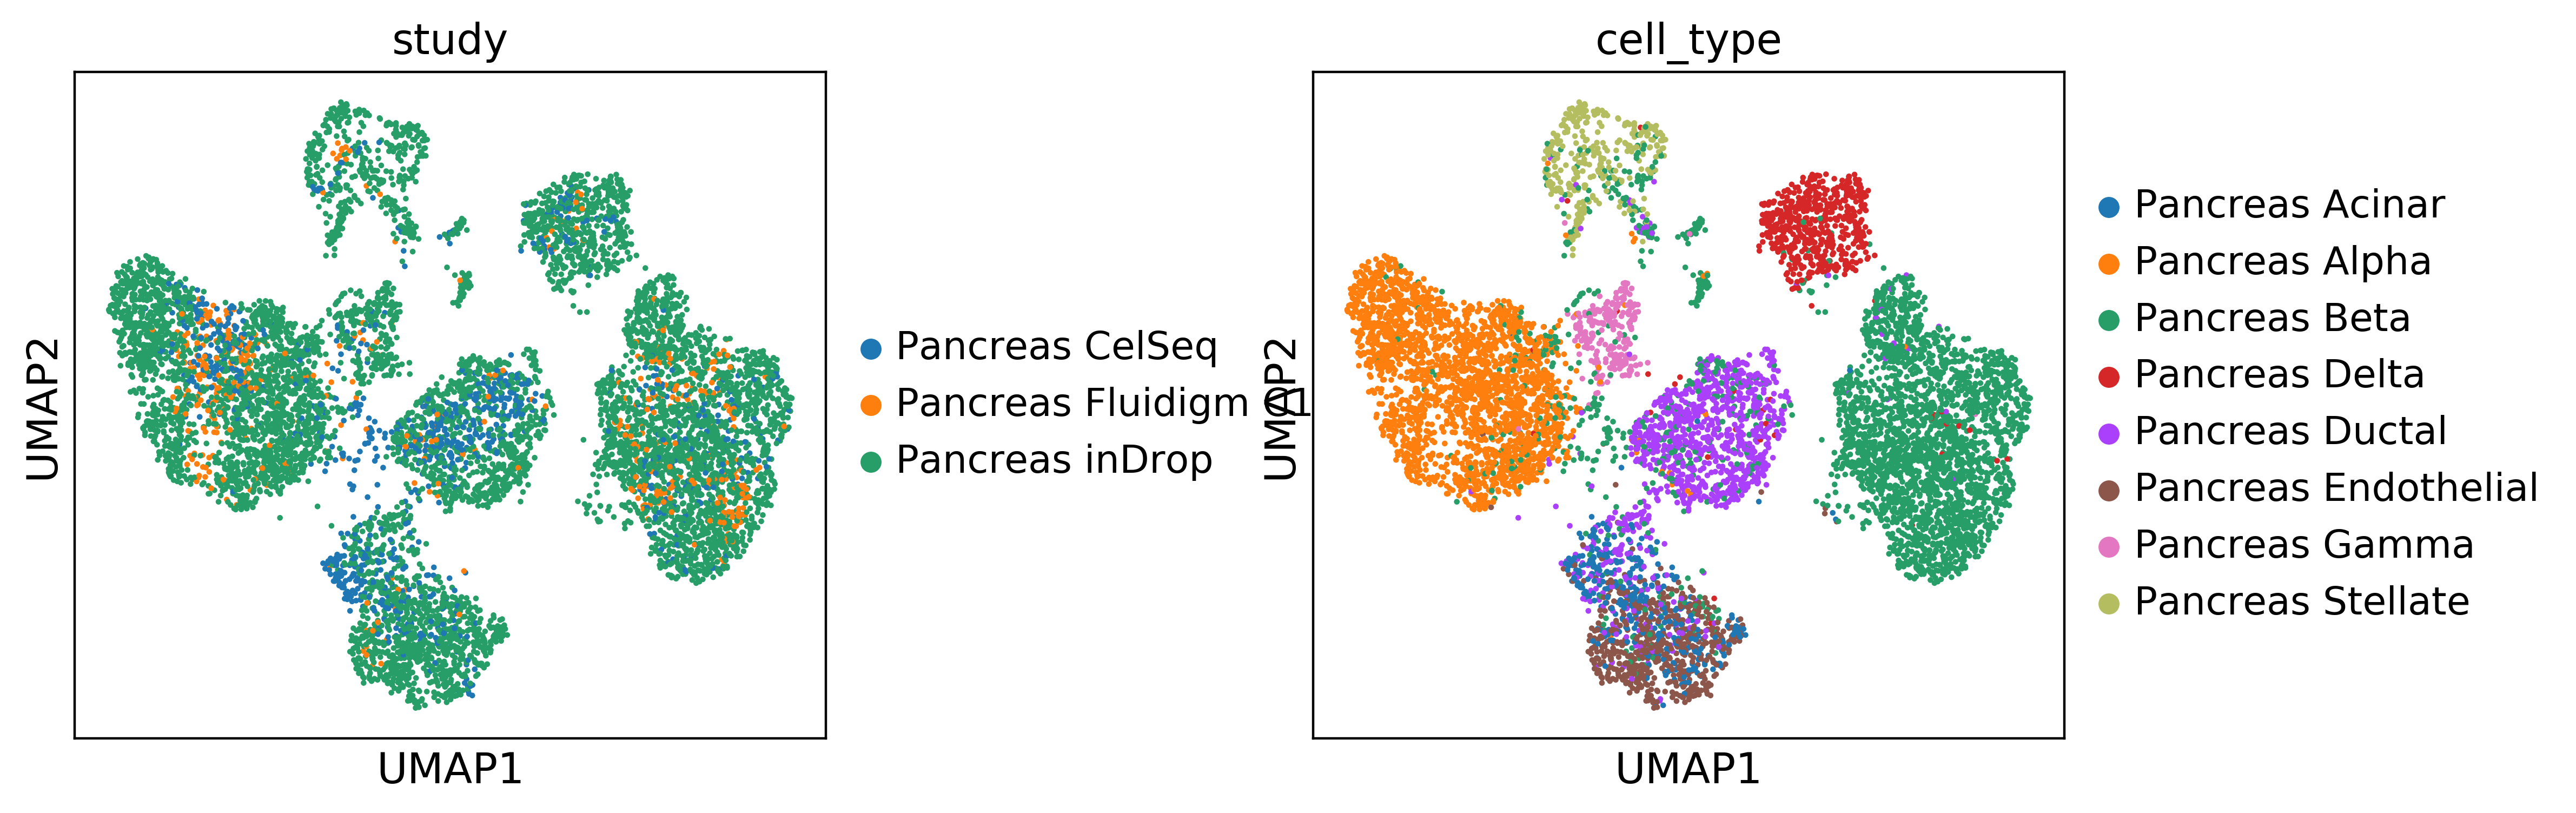

In [19]:
sc.pl.umap(latent_adata, color=[condition_key, cell_type_key], wspace=0.5)

In [20]:
surgeon.metrics.entropy_batch_mixing(latent_adata, condition_key, 15)

0.23688108228676275

In [21]:
surgeon.metrics.knn_purity(latent_adata, cell_type_key, 15)

0.8143271800478799

# Perfroming architecture Surgery

In [22]:
new_network = surgeon.operate(network, 
                              new_conditions=target_conditions,
                              init='Xavier', 
                              freeze_expression_input=True,
                              freeze=True)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
data (InputLayer)               (None, 1000)         0                                            
__________________________________________________________________________________________________
encoder_labels (InputLayer)     (None, 5)            0                                            
__________________________________________________________________________________________________
first_layer (FirstLayer)        (None, 128)          128640      data[0][0]                       
                                                                 encoder_labels[0][0]             
__________________________________________________________________________________________________
leaky_re_lu_7 (LeakyReLU)       (None, 128)          0           first_layer[0][0]                
__________

In [23]:
new_network.condition_encoder

{'Pancreas inDrop': 0,
 'Pancreas CelSeq': 1,
 'Pancreas Fluidigm C1': 2,
 'Pancreas SS2': 3,
 'Pancreas CelSeq2': 4}

## Train with small new dataset containing out-of-sample condition

In [24]:
train_adata, valid_adata = surgeon.utils.train_test_split(adata_out_of_sample, 0.80)

In [25]:
train_adata.shape, valid_adata.shape

((4309, 1000), (1078, 1000))

In [26]:
train_adata.obs[condition_key].value_counts()

Pancreas SS2        2369
Pancreas CelSeq2    1940
Name: study, dtype: int64

In [27]:
new_network.condition_encoder

{'Pancreas inDrop': 0,
 'Pancreas CelSeq': 1,
 'Pancreas Fluidigm C1': 2,
 'Pancreas SS2': 3,
 'Pancreas CelSeq2': 4}

In [28]:
new_network.train(train_adata,
                  valid_adata, 
                  condition_key=condition_key,
                  cell_type_key=cell_type_key,
                  n_per_epoch=0,
                  le=new_network.condition_encoder, 
                  n_epochs=1000,
                  batch_size=1024, 
                  early_stop_limit=50,
                  lr_reducer=40, 
                  save=False, 
                  verbose=2)

Train on 4309 samples, validate on 1078 samples
Epoch 1/1000
 - 1s - loss: 562.2010 - reconstruction_loss: 561.1253 - mmd_loss: 1.0748 - val_loss: 560.6540 - val_reconstruction_loss: 559.4431 - val_mmd_loss: 1.2100
Epoch 2/1000
 - 0s - loss: 561.9859 - reconstruction_loss: 560.9147 - mmd_loss: 1.0703 - val_loss: 560.3976 - val_reconstruction_loss: 559.1883 - val_mmd_loss: 1.2085
Epoch 3/1000
 - 0s - loss: 561.7636 - reconstruction_loss: 560.6876 - mmd_loss: 1.0750 - val_loss: 560.1998 - val_reconstruction_loss: 558.9894 - val_mmd_loss: 1.2094
Epoch 4/1000
 - 0s - loss: 561.5170 - reconstruction_loss: 560.4443 - mmd_loss: 1.0718 - val_loss: 559.9152 - val_reconstruction_loss: 558.7057 - val_mmd_loss: 1.2087
Epoch 5/1000
 - 0s - loss: 561.2802 - reconstruction_loss: 560.2046 - mmd_loss: 1.0747 - val_loss: 559.6709 - val_reconstruction_loss: 558.4622 - val_mmd_loss: 1.2078
Epoch 6/1000
 - 0s - loss: 561.0565 - reconstruction_loss: 559.9801 - mmd_loss: 1.0755 - val_loss: 559.4453 - val_rec

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/home/mohsen/.local/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 3325, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-28-58ba84bd0a04>", line 12, in <module>
    verbose=2)
  File "/home/mohsen/scnet/surgeon/models/_cvae.py", line 540, in train
    callbacks=callbacks,
  File "/home/mohsen/miniconda3/envs/venv/lib/python3.6/site-packages/keras/engine/training.py", line 1039, in fit
    validation_steps=validation_steps)
  File "/home/mohsen/miniconda3/envs/venv/lib/python3.6/site-packages/keras/engine/training_arrays.py", line 199, in fit_loop
    outs = f(ins_batch)
  File "/home/mohsen/miniconda3/envs/venv/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py", line 2715, in __call__
    return self._call(inputs)
  File "/home/mohsen/miniconda3/envs/venv/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py", line 2675, in _call
    fetched = self._callable_

KeyboardInterrupt: 

In [27]:
encoder_labels, _ = surgeon.utils.label_encoder(adata_out_of_sample, label_encoder=new_network.condition_encoder, condition_key=condition_key)

In [28]:
adata.obs[condition_key].value_counts()

Pancreas inDrop         8391
Pancreas SS2            2961
Pancreas CelSeq2        2426
Pancreas CelSeq         1271
Pancreas Fluidigm C1     632
Name: study, dtype: int64

In [29]:
latent_adata = new_network.to_mmd_layer(adata_out_of_sample, encoder_labels, encoder_labels)
latent_adata

AnnData object with n_obs × n_vars = 5387 × 32 
    obs: 'batch', 'study', 'cell_type', 'size_factors'

In [30]:
sc.pp.neighbors(latent_adata)
sc.tl.umap(latent_adata)

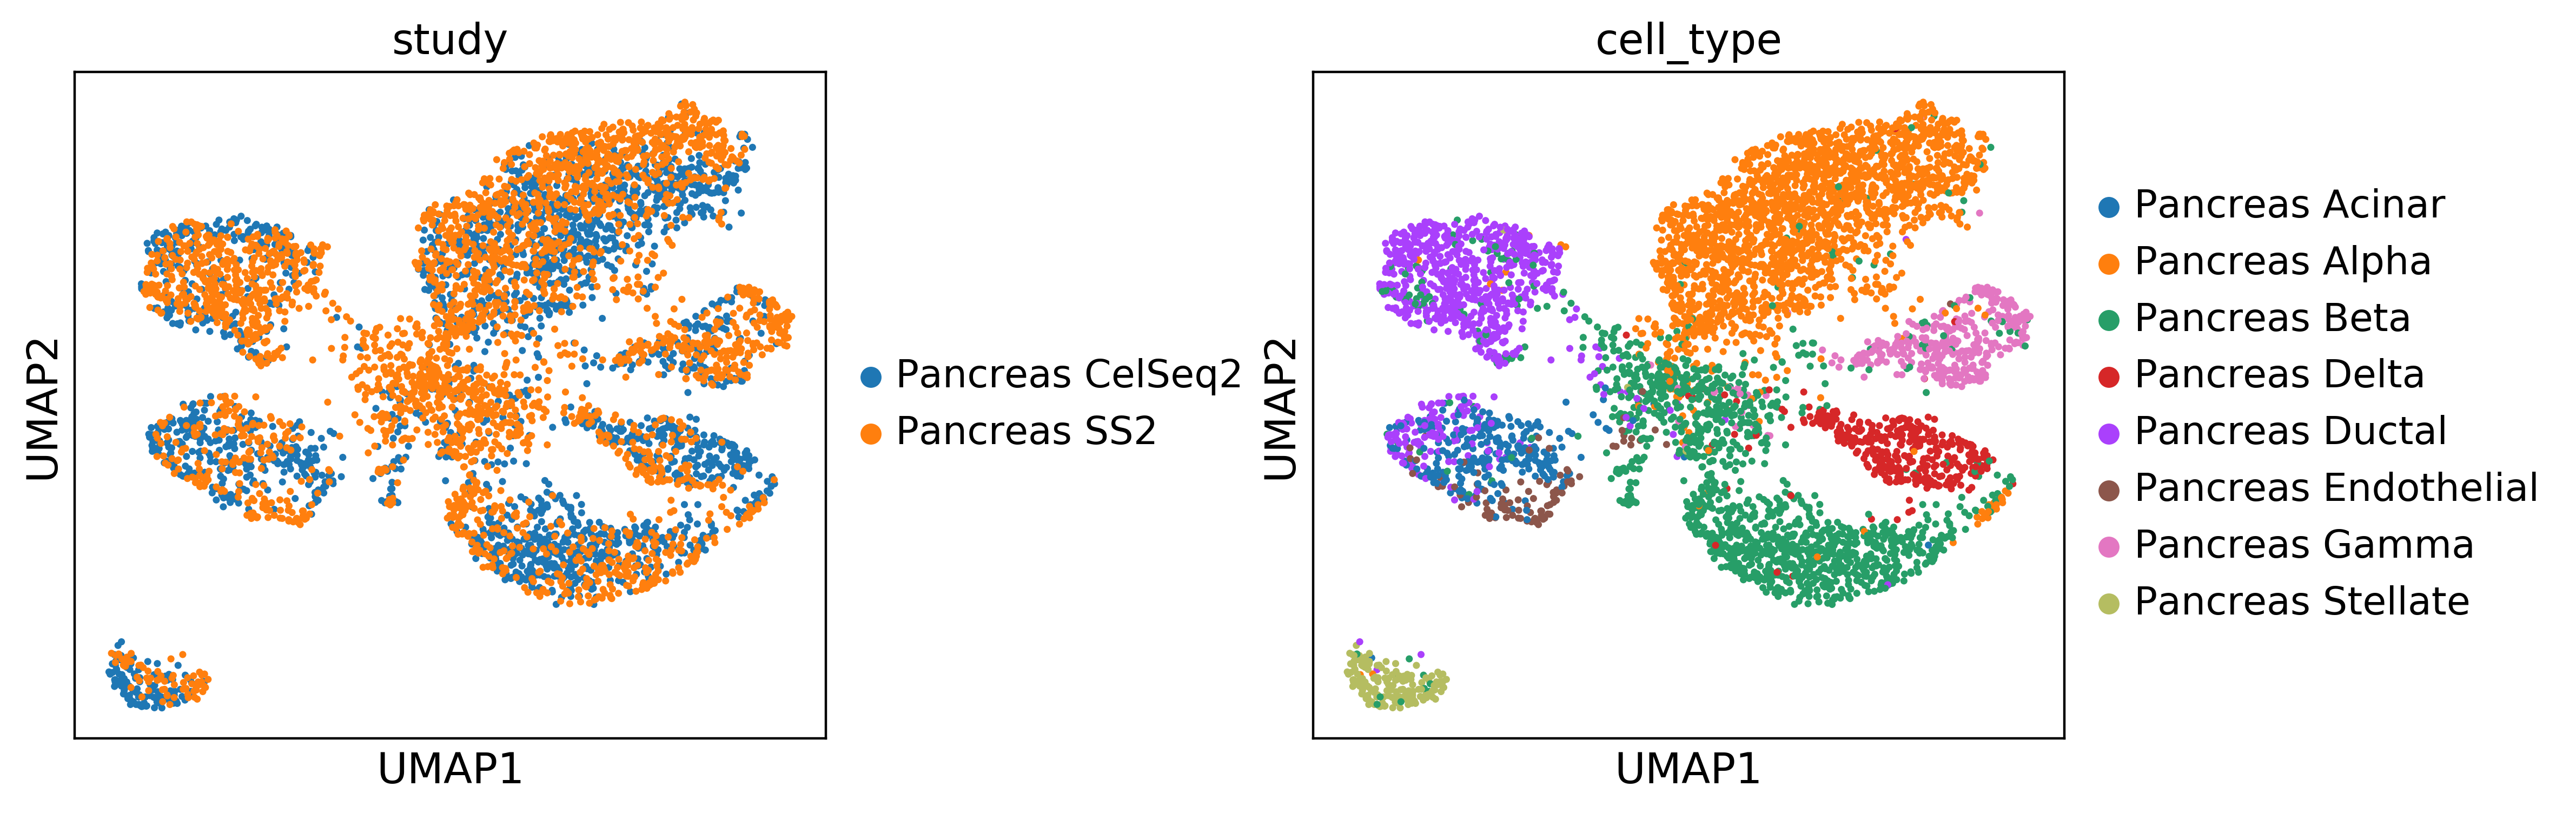

In [31]:
sc.pl.umap(latent_adata, color=[condition_key, cell_type_key], wspace=0.5)

In [32]:
surgeon.metrics.knn_purity(latent_adata, cell_type_key, 15)

0.822699688755753

In [33]:
surgeon.metrics.entropy_batch_mixing(latent_adata, condition_key, 15)

0.4337399009854076